# Imputation Experiment

In [1]:
import os, sys, pandas as pd, wfdb, tqdm, pickle, scipy, time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt, librosa
from scipy.signal import spectrogram
from scipy import interpolate
import torch, torchvision, torch.nn as nn
import numpy as np, librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import numba
from tqdm import tqdm, trange, tgrange
import random
from IPython.display import Audio
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
sys.path = ['/N/project/waveform_mortality/rmahawar/'] + sys.path

In [3]:
from data_utils import *

In [4]:
waveform_path = '/N/project/waveform_mortality/shared/datasets/waveform_datasets/mimic-iii-waveform-database-1.0-demo/physionet.org/files/mimic3wdb-matched/1.0/'

In [5]:
s = time.time()
signals, fields = wfdb.rdsamp(record_name= os.path.join(waveform_path, 'p00', 'p000033', 'p000033-2116-12-24-12-35'), sampfrom= 14500, sampto= 15500)
e = time.time()

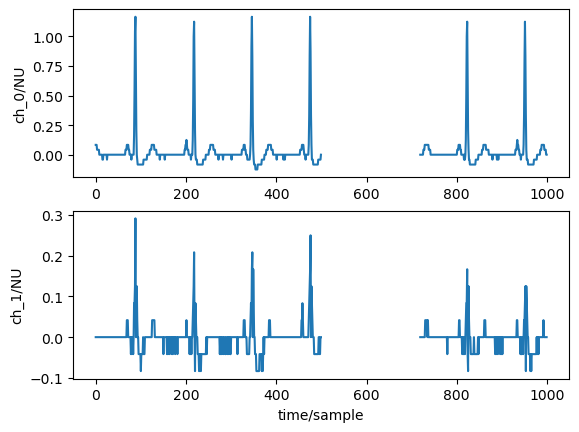

In [6]:
wfdb.plot_items(signal= signals, fs= fields['fs'])

### 1. Interpolation

In [ ]:
def impute(sig, method = 'interp1d', kind = 'linear'):
    sig = sig.copy()
    mask = np.where(np.isnan(sig))[0]
    idx = np.where(~np.isnan(sig))[0]

    if method == 'interp1d':
        f = interpolate.interp1d(idx, sig[idx], kind)
    
    sig[mask] = f(mask)
    return sig

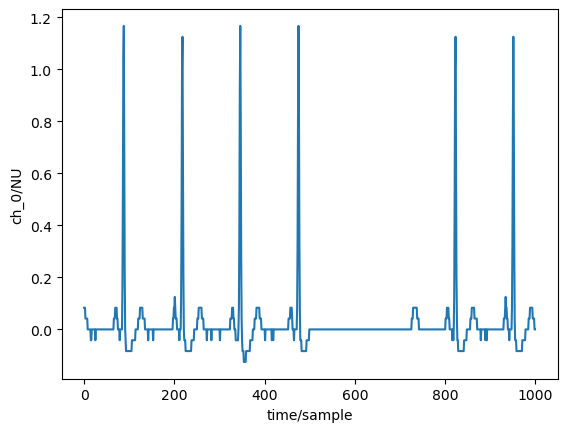

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0]), fs= fields['fs'])

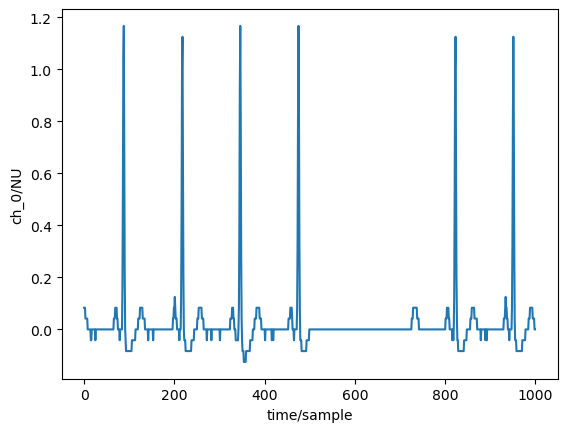

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'nearest'), fs= fields['fs'])

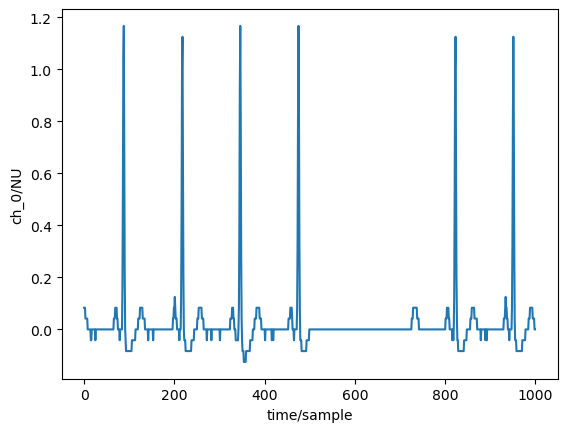

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'nearest-up'), fs= fields['fs'])

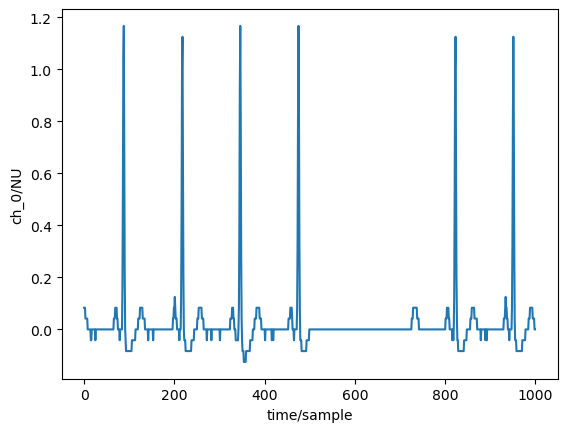

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'zero'), fs= fields['fs'])

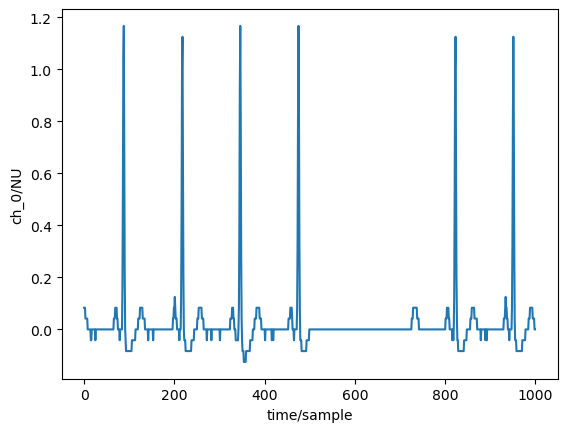

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'slinear'), fs= fields['fs'])

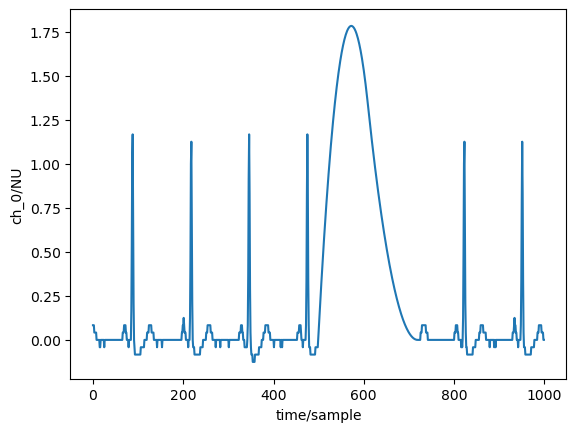

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'quadratic'), fs= fields['fs'])

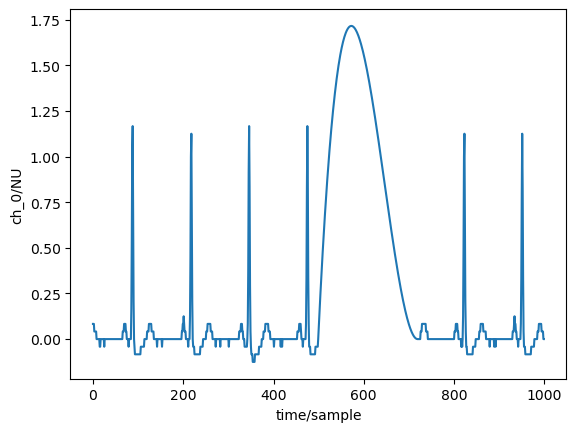

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'cubic'), fs= fields['fs'])

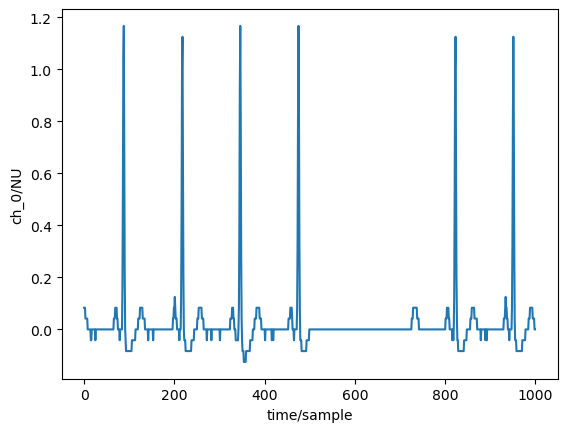

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'previous'), fs= fields['fs'])

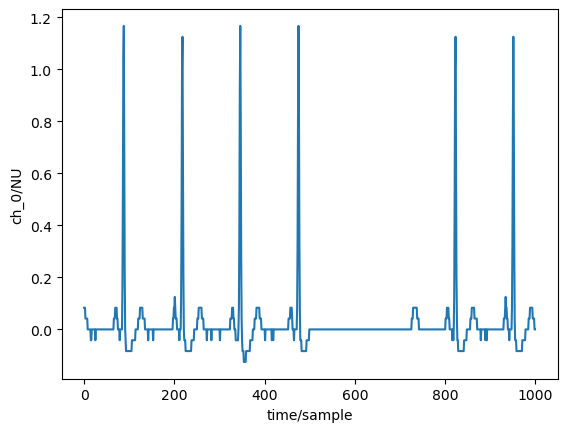

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'next'), fs= fields['fs'])

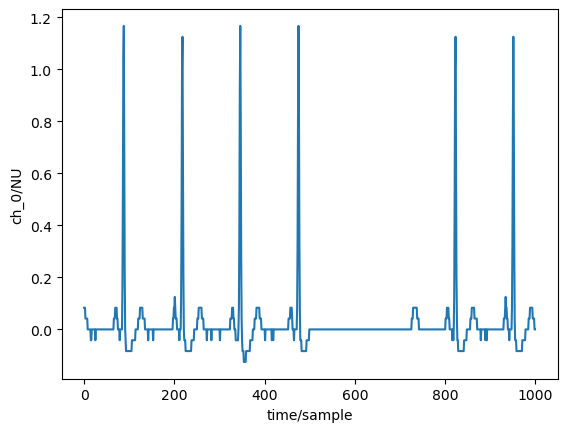

In [ ]:
wfdb.plot_items(signal= impute(signals[:, 0], kind= 'slinear'), fs= fields['fs'])

### 2. Forward Fill & Backward Fill

In [ ]:
sig = signals[:, 0]
sig.shape

(1000,)

In [ ]:
fill1 = pd.DataFrame(sig)
fill1 = fill1.fillna(method = 'bfill', inplace= False)

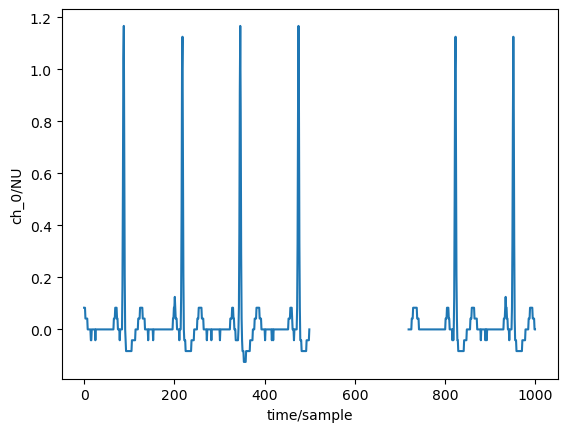

In [ ]:
# wfdb.plot_items(signal= np.array(fill1), fs= fields['fs'])
wfdb.plot_items(signal= sig, fs= fields['fs'])

In [ ]:
fill2 = pd.DataFrame(sig)
fill2 = fill2.fillna(method = 'ffill', inplace= False)

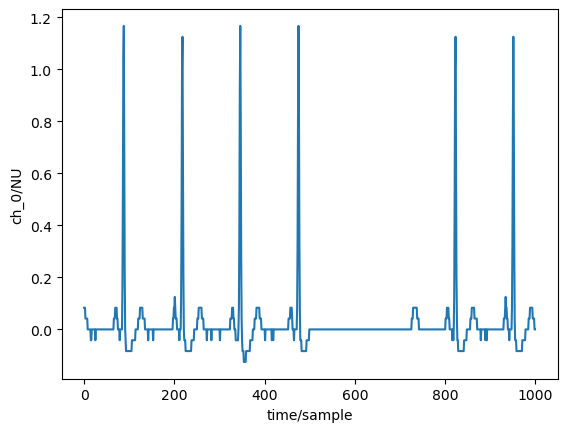

In [ ]:
wfdb.plot_items(signal= np.array(fill1), fs= fields['fs'])
# wfdb.plot_items(signal= sig, fs= fields['fs'])

### 3. Borrow from neighbour

In [ ]:
# Assumption: There is enough data from left or right neighbour to borrow from
def borrow(signal):
    if np.isnan(signal).sum() == 0:
        return signal
    start = -1 
    end = -1
    for idx, val in enumerate(signal):
        if start == -1 and np.isnan(val):
            start = idx 
        elif start != -1 and ~np.isnan(val):
            end = idx 
            curr_len = end - start

            if start - curr_len >= 0 and end + curr_len <= len(signal) and np.isnan(signal[end: end + curr_len]).sum() == 0: 
                signal[start: end] = (signal[start - curr_len : start] + signal[end: end + curr_len])/2 # average of both forward and backward window
            elif start - curr_len >= 0:
                signal[start: end] = signal[start - curr_len : start] # bFill
            elif end + curr_len <= len(signal) and np.isnan(signal[end: end + curr_len]).sum() == 0:
                signal[start: end] = signal[end: end + curr_len] # FFill
            else:
                raise Exception('No window available to borrow for imputation!')
            
            start = -1
    
    return signal

In [14]:
x= np.array(reversed(signals[:, 0]))
x.shape

()

In [7]:
x = borrow(signals[:, 0])
x.shape

(1000,)

In [9]:
x[(1000 - 125*2):].shape

(250,)

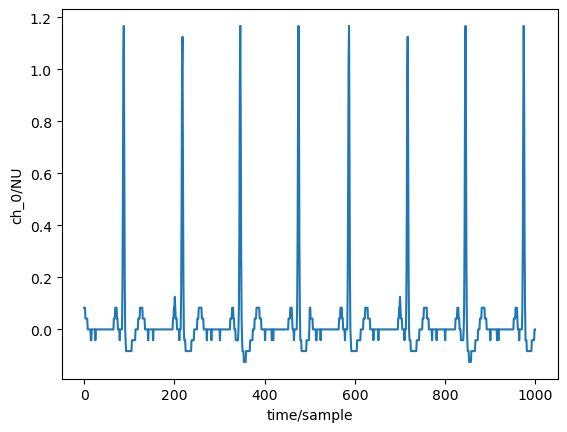

In [7]:
wfdb.plot_items(signal= borrow(signals[:, 0]), fs= fields['fs'])